# HOMEWORK 13

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<ipython-input-2-25da4b6bfa24>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


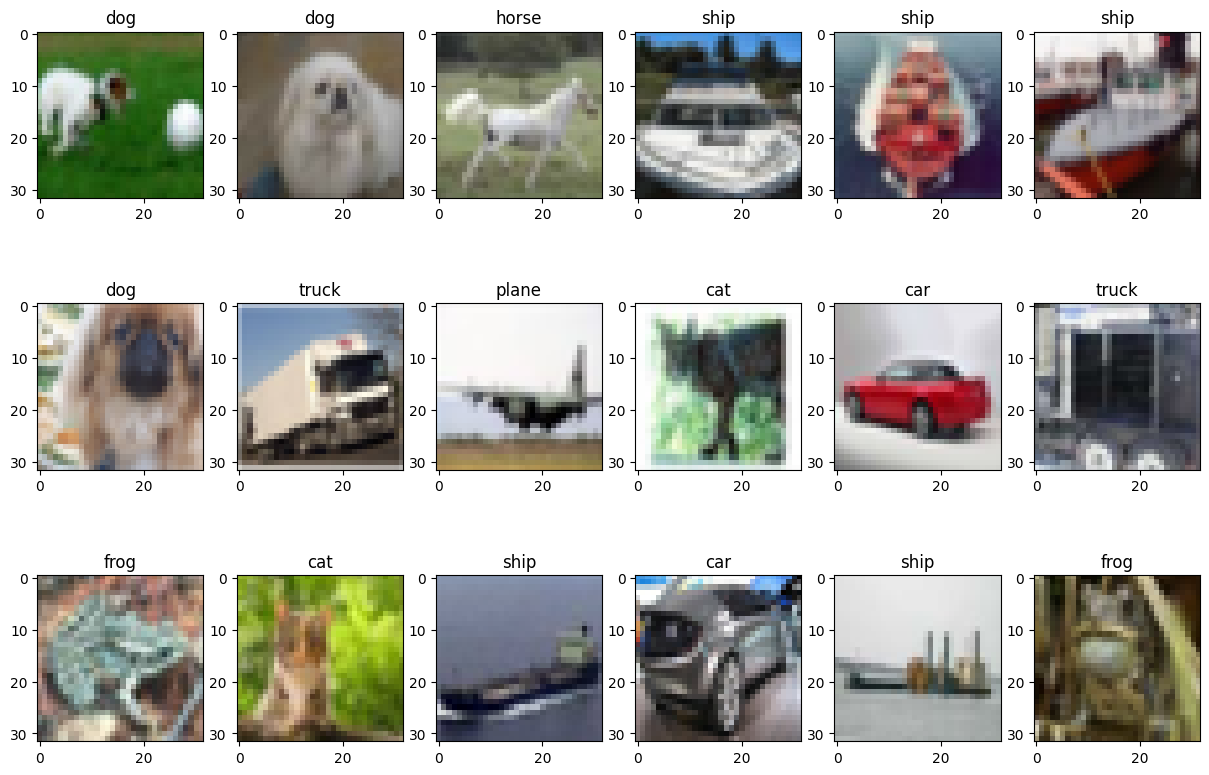

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(0, len(y_train))
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

(Text(0.5, 0, 'Class ID'), Text(0, 0.5, 'Counts'))

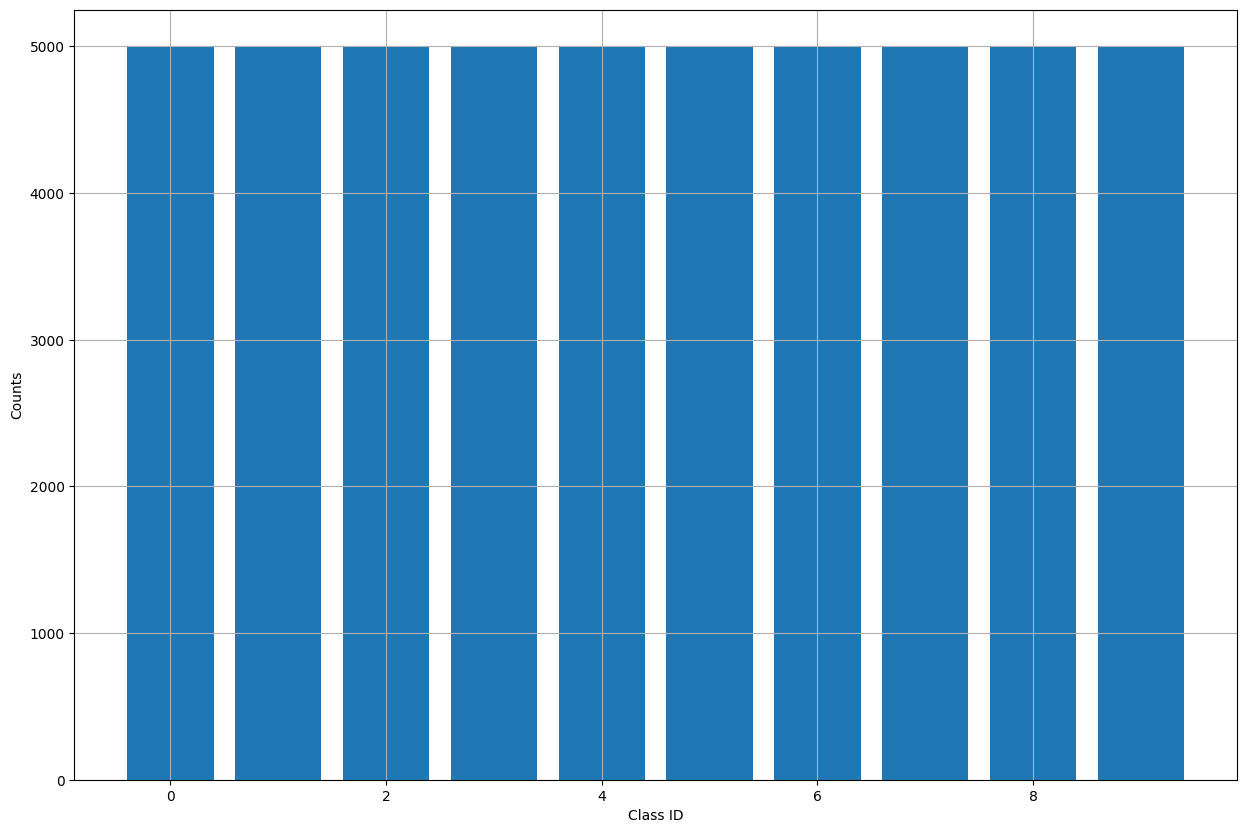

In [10]:
# Compute the class histogram
from collections import Counter
hist = Counter(y_train.flatten())
plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xlabel('Class ID'), plt.ylabel('Counts')
# distribution is completley uniform

### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [11]:
# Normalization
from tensorflow.keras.utils import to_categorical

x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [15]:
# Build the classifier
# same as in lecture, but with 3 channels
inputs = Input(shape=(size, size, 3))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
# show the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          11,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,618 (64.91 KB)

 Trainable params: 16,618 (64.91 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [16]:
epochs = 25
batch_size = 128

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.3008 - loss: 1.9317 - val_accuracy: 0.4540 - val_loss: 1.5472
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.4880 - loss: 1.4554 - val_accuracy: 0.5034 - val_loss: 1.4098
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - accuracy: 0.5312 - loss: 1.3456 - val_accuracy: 0.5316 - val_loss: 1.3179
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.5554 - loss: 1.2765 - val_accuracy: 0.5598 - val_loss: 1.2571
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - accuracy: 0.5752 - loss: 1.2225 - val_accuracy: 0.5840 - val_loss: 1.2077
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - accuracy: 0.5924 - loss: 1.1764 - val_accuracy: 0.5972 - val_loss: 1.1676
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.6074 - loss: 1.1381 - val_accuracy: 0.6050 - val_loss: 1.1364
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.6196 - loss: 1.1054

Train Acc      0.7035555839538574
Validation Acc 0.6625999808311462


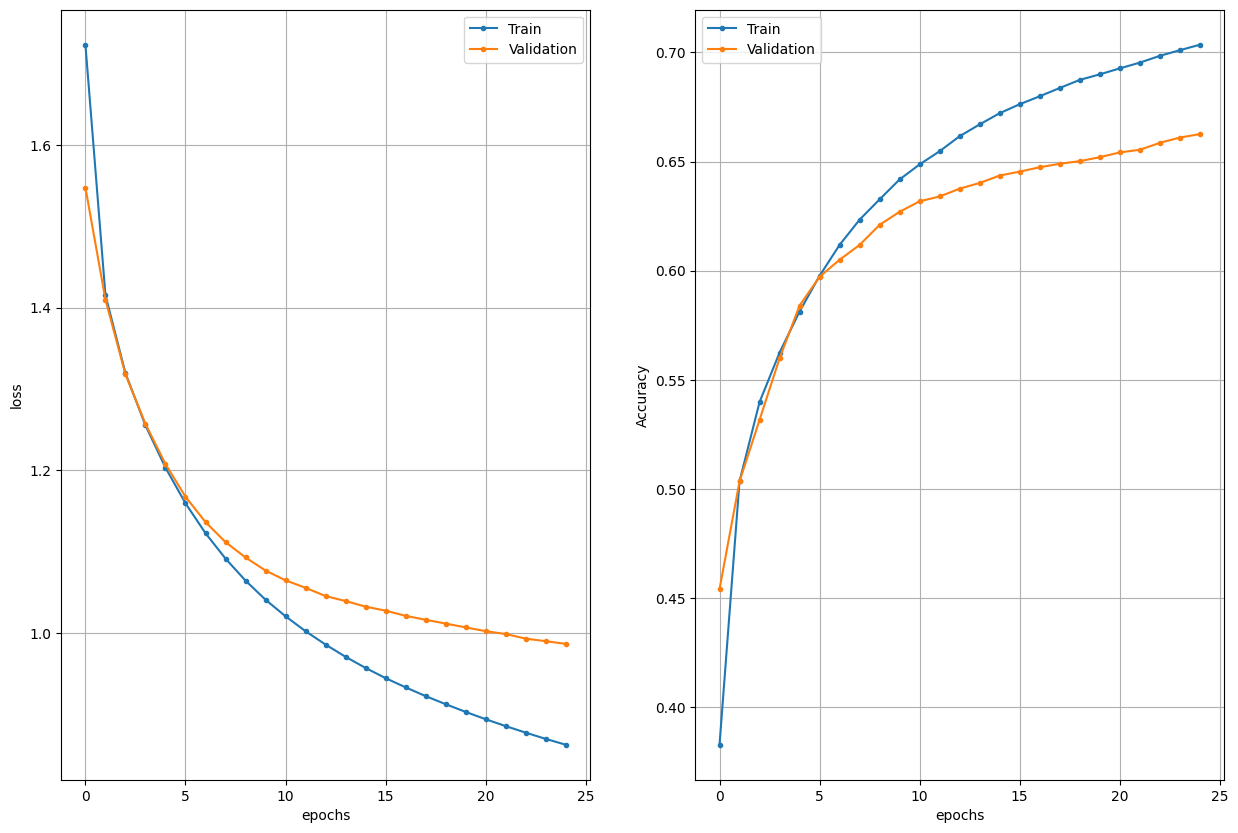

In [17]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [18]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [22]:
# Compute and print the accuracy for each class
y_pred_labels = np.argmax(y_pred, axis=1)
for class_id, class_name in classes.items():
    class_true = y_true == class_id
    class_pred = y_pred_labels == class_id
    correct_predictions = np.sum(class_true & class_pred)
    acc = correct_predictions/np.sum(class_true)
    print(class_name, acc)

plane 0.714
car 0.834
bird 0.449
cat 0.43
deer 0.711
dog 0.601
frog 0.733
horse 0.728
ship 0.655
truck 0.729


In [23]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6588 - loss: 0.9942
Test loss   1.0084482431411743
Test metric 0.6583999991416931


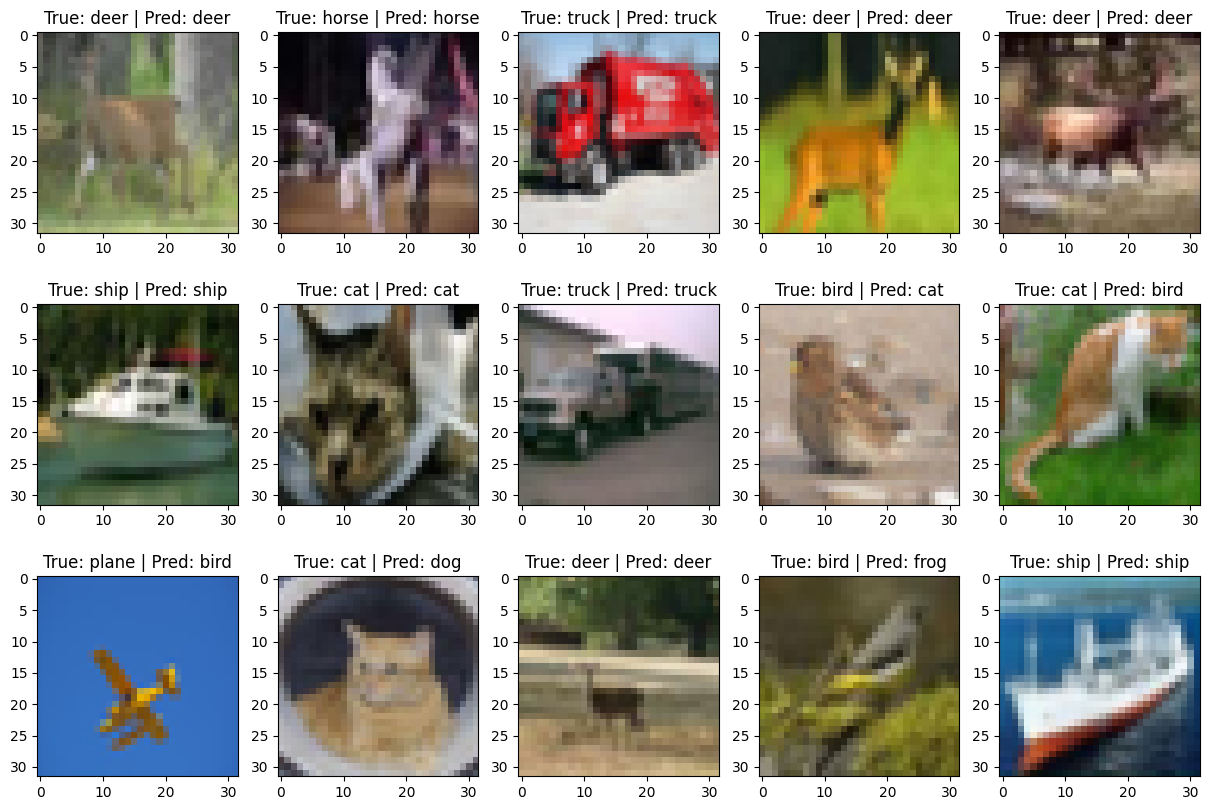

In [31]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, len(y_pred))
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred_labels[idx]]))

### Questions
* What is the overall accuracy of the classifier?
* What modifications would you do in order to improve the classification accuracy?
* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?

The overall accuracy is ~65.84%. First I wanted to say "somewhat better than a coin toss", but then I remembered that it is not binary, but 10 classes. So it is much better than imaginary 10 sided coin toss :) (still not great?)